In [80]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e1/sample_submission.csv
/kaggle/input/playground-series-s5e1/train.csv
/kaggle/input/playground-series-s5e1/test.csv


# 1. Initial Data Exploration and Preprocessing:

## First, let's analyze the structure and patterns in your data:

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
train_df = pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv')

# Basic info
print("Train dataset info:")
print(train_df.info())
print("\nMissing values:")
print(train_df.isnull().sum())

Train dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB
None

Missing values:
id             0
date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64


In [82]:
# Basic info
print("Test dataset info:")
print(test_df.info())
print("\nMissing values:")
print(test_df.isnull().sum())

Test dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98550 entries, 0 to 98549
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       98550 non-null  int64 
 1   date     98550 non-null  object
 2   country  98550 non-null  object
 3   store    98550 non-null  object
 4   product  98550 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None

Missing values:
id         0
date       0
country    0
store      0
product    0
dtype: int64


In [83]:
# Convert date column to datetime
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

# 2. Analyze Missing Value Patterns:


Missing values by Country:
country
Canada    4246
Kenya     4625
dtype: int64

Missing values by Store:
store
Discount Stickers       5179
Premium Sticker Mart    1026
Stickers for Less       2666
dtype: int64

Missing values by Product:
product
Holographic Goose     8806
Kerneler                64
Kerneler Dark Mode       1
dtype: int64


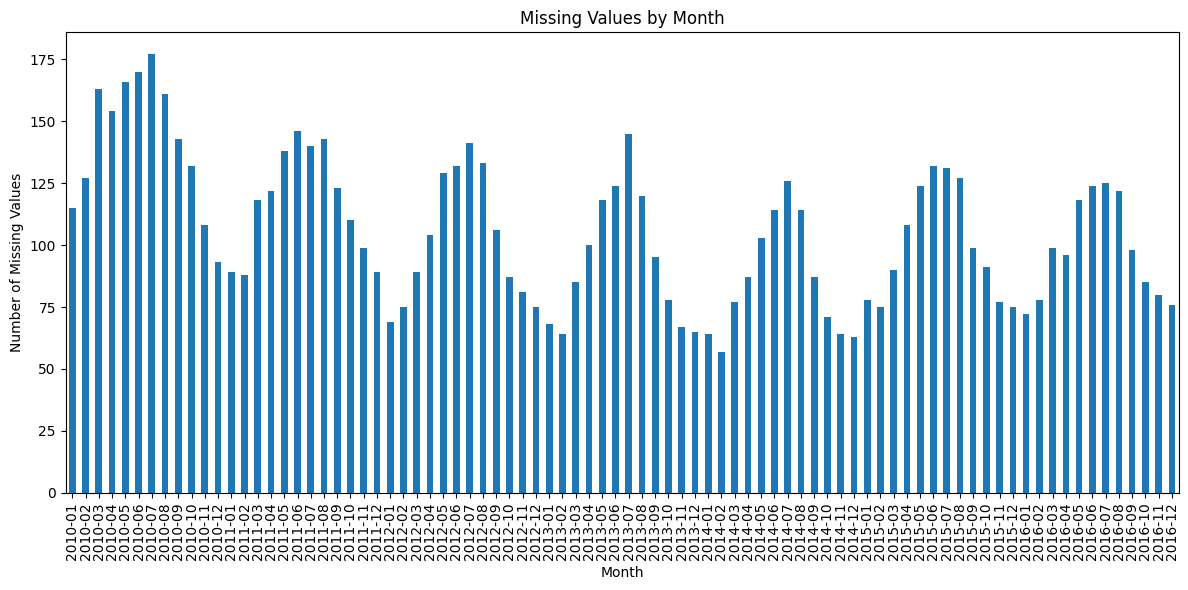

In [84]:
def analyze_missing_values(df):
    # Check if missing values are specific to certain categories
    missing_by_country = df[df['num_sold'].isnull()].groupby('country').size()
    missing_by_store = df[df['num_sold'].isnull()].groupby('store').size()
    missing_by_product = df[df['num_sold'].isnull()].groupby('product').size()
    
    print("\nMissing values by Country:")
    print(missing_by_country)
    print("\nMissing values by Store:")
    print(missing_by_store)
    print("\nMissing values by Product:")
    print(missing_by_product)
    
    # Visualize missing value distribution
    plt.figure(figsize=(12,6))
    df['date'] = pd.to_datetime(df['date'])
    missing_by_date = df[df['num_sold'].isnull()].groupby(df['date'].dt.to_period('M')).size()
    missing_by_date.plot(kind='bar')
    plt.title('Missing Values by Month')
    plt.xlabel('Month')
    plt.ylabel('Number of Missing Values')
    plt.tight_layout()
    plt.show()

analyze_missing_values(train_df)

Missing Value Summary:
          Total_Missing  Percent_Missing
num_sold           8871         3.854778

Missing Value Imputation Validation:
Original Missing Values: 8871
Imputed Missing Values: 0


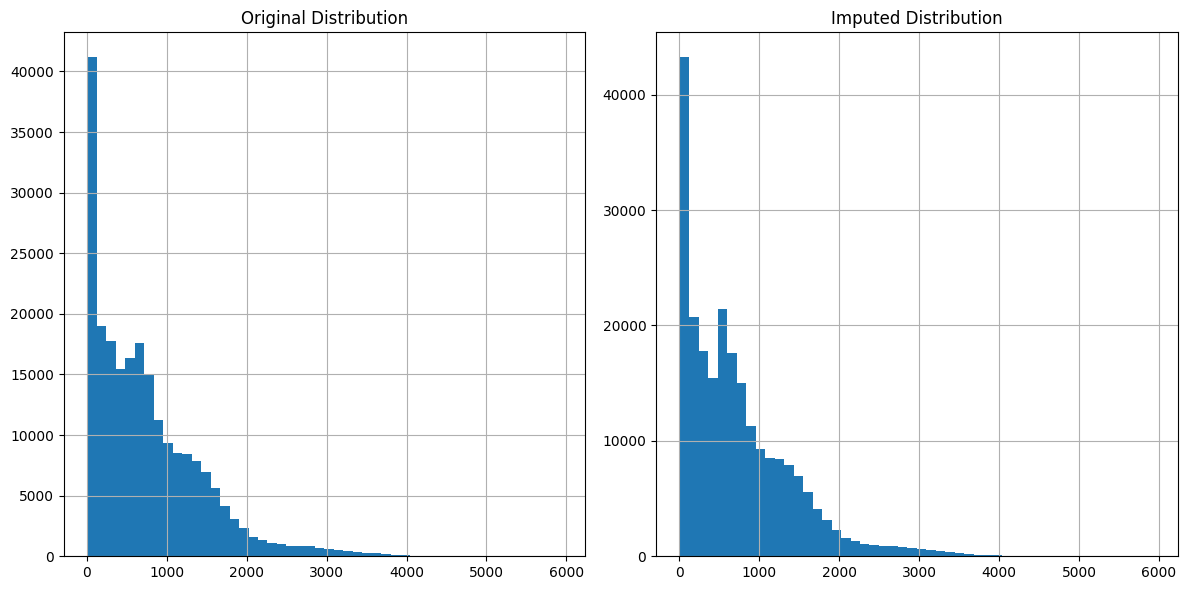


Original Data Statistics:
count    221259.000000
mean        752.527382
std         690.165445
min           5.000000
25%         219.000000
50%         605.000000
75%        1114.000000
max        5939.000000
Name: num_sold, dtype: float64

Imputed Data Statistics:
count    230130.000000
mean        738.308152
std         682.252686
min           5.000000
25%         215.578571
50%         592.000000
75%        1084.000000
max        5939.000000
Name: num_sold, dtype: float64


In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def advanced_missing_value_treatment(df):
    # Create a copy of the dataframe
    processed_df = df.copy()
    
    # Detailed missing value analysis
    def missing_value_report(df):
        missing_summary = pd.DataFrame({
            'Total_Missing': df.isnull().sum(),
            'Percent_Missing': df.isnull().sum() / len(df) * 100
        })
        print("Missing Value Summary:")
        print(missing_summary[missing_summary['Total_Missing'] > 0])
        return missing_summary
    
    missing_summary = missing_value_report(processed_df)
    
    # Prepare date column
    processed_df['date'] = pd.to_datetime(processed_df['date'])
    
    # Imputation Strategy
    def impute_group(group):
        # If all values are missing, skip
        if group['num_sold'].isnull().all():
            return group
        
        # Interpolation within group
        group['num_sold'] = group['num_sold'].interpolate(method='linear')
        
        # Fill remaining NaNs with group median
        group_median = group['num_sold'].median()
        group['num_sold'] = group['num_sold'].fillna(group_median)
        
        return group
    
    # Apply group-specific imputation
    processed_df = (
        processed_df.groupby(['country', 'store', 'product'], group_keys=False)
        .apply(impute_group)
    )
    
    # Final fallback - global median
    overall_median = processed_df['num_sold'].median()
    processed_df['num_sold'] = processed_df['num_sold'].fillna(overall_median)
    
    # Confidence Scoring (Simplified)
    def calculate_confidence(row, original_df):
        # Check if this row was originally missing
        was_missing = original_df.loc[row.name, 'num_sold'] is np.nan
        
        if not was_missing:
            return 1.0  # Original values have full confidence
        
        # Determine imputation method
        group = original_df.loc[row.name, ['country', 'store', 'product']]
        group_data = original_df[
            (original_df['country'] == group['country']) & 
            (original_df['store'] == group['store']) & 
            (original_df['product'] == group['product'])
        ]
        
        # If interpolated within group
        if row['num_sold'] in group_data['num_sold'].values:
            return 0.7  # Moderate confidence for interpolated values
        
        # If filled with global median
        return 0.3  # Low confidence for global median imputation
    
    # Add confidence column
    processed_df['imputation_confidence'] = processed_df.apply(
        lambda row: calculate_confidence(row, df), 
        axis=1
    )
    
    # Validation
    def imputation_validation(original, imputed):
        print("\nMissing Value Imputation Validation:")
        print(f"Original Missing Values: {original['num_sold'].isnull().sum()}")
        print(f"Imputed Missing Values: {imputed['num_sold'].isnull().sum()}")
        
        # Visualize distribution
        plt.figure(figsize=(12,6))
        plt.subplot(1,2,1)
        original['num_sold'].hist(bins=50)
        plt.title('Original Distribution')
        
        plt.subplot(1,2,2)
        imputed['num_sold'].hist(bins=50)
        plt.title('Imputed Distribution')
        
        plt.tight_layout()
        plt.show()
        
        # Statistical comparison
        print("\nOriginal Data Statistics:")
        print(original['num_sold'].describe())
        
        print("\nImputed Data Statistics:")
        print(imputed['num_sold'].describe())
    
    # Perform validation
    imputation_validation(df, processed_df)
    
    return processed_df

# Apply the advanced missing value treatment
train_df_processed = advanced_missing_value_treatment(train_df)

In [86]:
print("\nMissing values:")
print(train_df_processed.isnull().sum())


Missing values:
id                       0
date                     0
country                  0
store                    0
product                  0
num_sold                 0
imputation_confidence    0
dtype: int64


# 3. Feature Engineering:

## Let's create relevant features for time series analysis:

In [87]:
def create_time_features(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    return df

train_df = create_time_features(train_df_processed)
test_df = create_time_features(test_df)

In [88]:
train_df.head()

,id,date,country,store,product,num_sold,imputation_confidence,year,month,day,day_of_week,quarter
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,592.0,1.0,2010,1,1,4,1
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,1.0,2010,1,1,4,1
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,1.0,2010,1,1,4,1
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,1.0,2010,1,1,4,1
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,1.0,2010,1,1,4,1


In [89]:
train_df.tail()

,id,date,country,store,product,num_sold,imputation_confidence,year,month,day,day_of_week,quarter
230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0,1.0,2016,12,31,5,4
230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0,1.0,2016,12,31,5,4
230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0,1.0,2016,12,31,5,4
230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0,1.0,2016,12,31,5,4
230129,230129,2016-12-31,Singapore,Premium Sticker Mart,Kerneler Dark Mode,1622.0,1.0,2016,12,31,5,4


# 4. Exploratory Data Analysis (EDA):

## Let's analyze patterns and relationships:

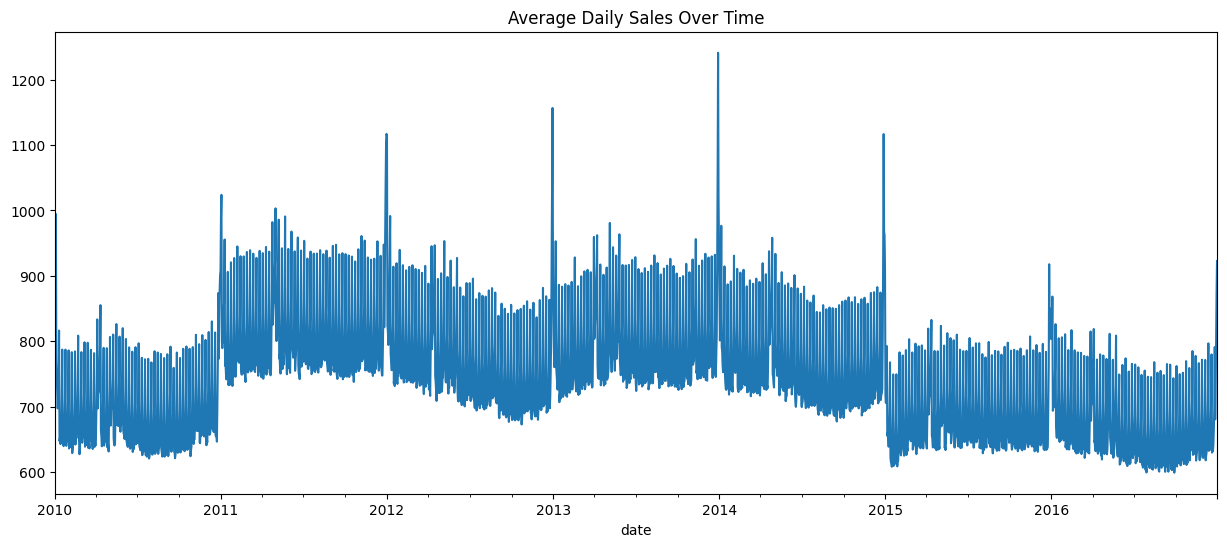

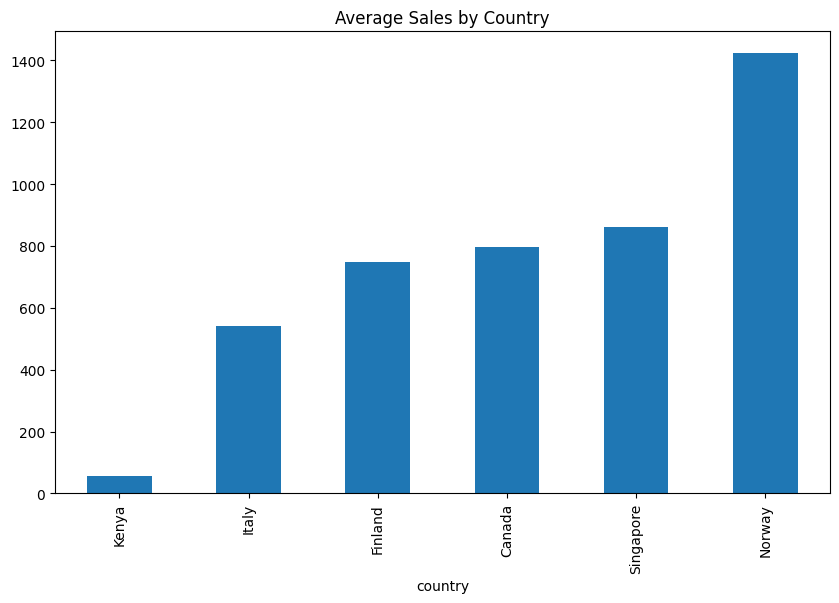

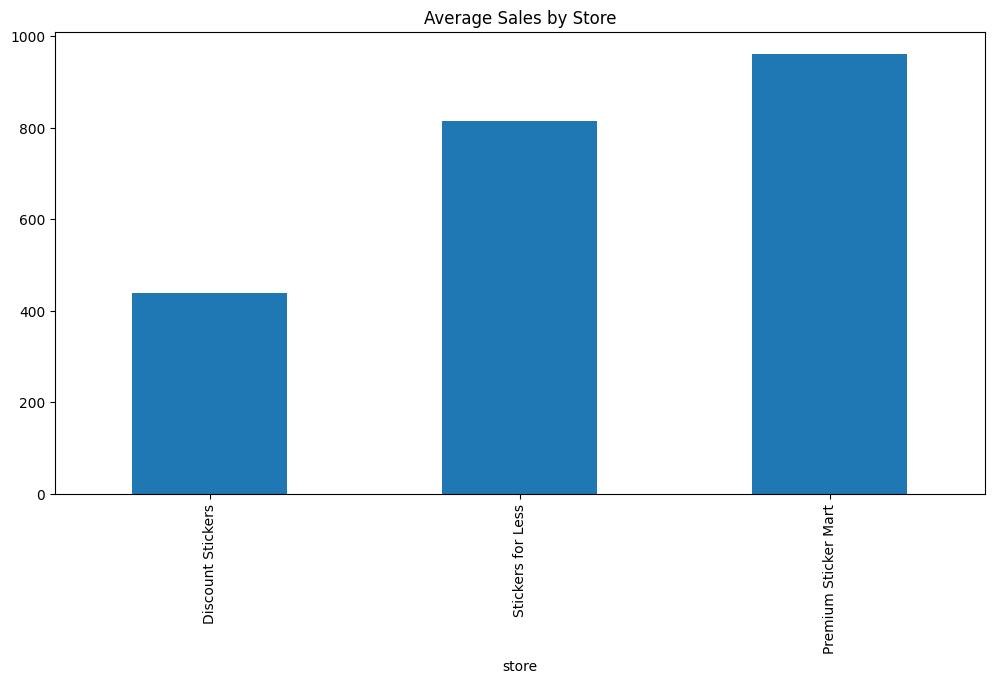

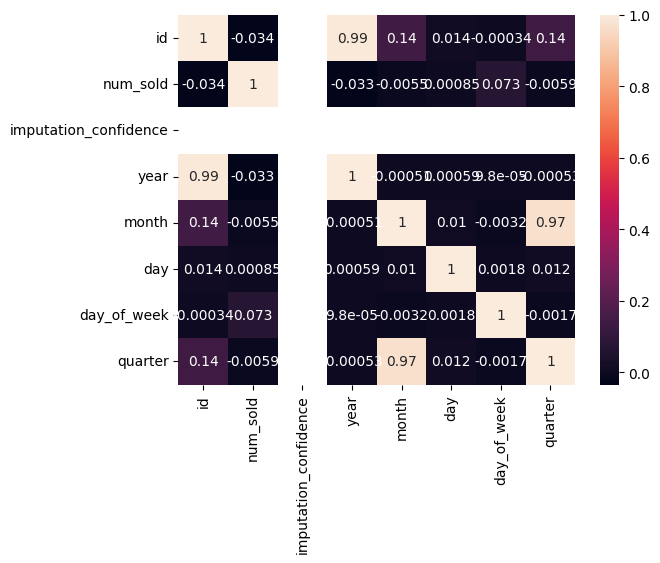

In [91]:
# Time series analysis
plt.figure(figsize=(15,6))
train_df.groupby('date')['num_sold'].mean().plot()
plt.title('Average Daily Sales Over Time')
plt.show()

# Sales by country
plt.figure(figsize=(10,6))
train_df.groupby('country')['num_sold'].mean().sort_values().plot(kind='bar')
plt.title('Average Sales by Country')
plt.show()

# Sales by store
plt.figure(figsize=(12,6))
train_df.groupby('store')['num_sold'].mean().sort_values().plot(kind='bar')
plt.title('Average Sales by Store')
plt.show()

# Correlation analysis
numerical_cols = train_df.select_dtypes(include=[np.number]).columns
correlation = train_df[numerical_cols].corr()
sns.heatmap(correlation, annot=True)
plt.show()

# 5. Statistical Analysis:
## Let's understand the time series components:

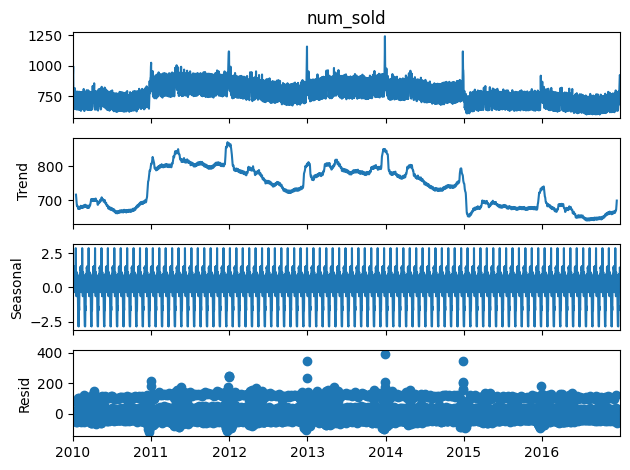

In [92]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Aggregate daily sales
daily_sales = train_df.groupby('date')['num_sold'].mean()

# Decompose time series
decomposition = seasonal_decompose(daily_sales, period=30)  # assuming monthly seasonality
decomposition.plot()
plt.show()

# 6. Feature Preparation:
## Let's prepare our features for modeling:

In [93]:
def prepare_features(df):
    # Create a copy to avoid modifying the original dataframe
    processed_df = df.copy().reset_index(drop=True)
    
    # Convert date to datetime
    processed_df['date'] = pd.to_datetime(processed_df['date'])
    
    # Create lag features with careful handling
    def create_lag_features(group):
        # Sort by date to ensure correct lag calculation
        group_sorted = group.sort_values('date')
        
        # Create lag features
        group_sorted['lag_1'] = group_sorted['num_sold'].shift(1)
        group_sorted['lag_7'] = group_sorted['num_sold'].shift(7)
        
        return group_sorted
    
    # Apply lag feature creation
    processed_df = (
        processed_df.groupby(['store', 'product'], group_keys=False)
        .apply(create_lag_features)
        .reset_index(drop=True)
    )
    
    # Create rolling window features
    def create_rolling_features(group):
        # Sort by date
        group_sorted = group.sort_values('date')
        
        # Rolling mean features
        group_sorted['rolling_mean_7'] = group_sorted['num_sold'].rolling(window=7, min_periods=1).mean()
        group_sorted['rolling_mean_30'] = group_sorted['num_sold'].rolling(window=30, min_periods=1).mean()
        
        return group_sorted
    
    processed_df = (
        processed_df.groupby(['store', 'product'], group_keys=False)
        .apply(create_rolling_features)
        .reset_index(drop=True)
    )
    
    # Additional time-based features
    processed_df['year'] = processed_df['date'].dt.year
    processed_df['month'] = processed_df['date'].dt.month
    processed_df['day'] = processed_df['date'].dt.day
    processed_df['day_of_week'] = processed_df['date'].dt.dayofweek
    processed_df['quarter'] = processed_df['date'].dt.quarter
    
    # Create combined categorical features
    processed_df['store_product'] = processed_df['store'] + '_' + processed_df['product']
    
    # Handle potential NaN in lag and rolling features
    lag_columns = ['lag_1', 'lag_7', 'rolling_mean_7', 'rolling_mean_30']
    for col in lag_columns:
        processed_df[col] = processed_df[col].fillna(processed_df[col].median())
    
    return processed_df

# Apply feature preparation
train_df_with_features = prepare_features(train_df)

In [94]:
train_df_with_features.head()

,id,date,country,store,product,num_sold,imputation_confidence,year,month,day,day_of_week,quarter,lag_1,lag_7,rolling_mean_7,rolling_mean_30,store_product
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,592.0,1.0,2010,1,1,4,1,592.0,592.0,592.0,592.0,Discount Stickers_Holographic Goose
1,15,2010-01-01,Finland,Discount Stickers,Holographic Goose,150.0,1.0,2010,1,1,4,1,592.0,592.0,371.0,371.0,Discount Stickers_Holographic Goose
2,30,2010-01-01,Italy,Discount Stickers,Holographic Goose,110.0,1.0,2010,1,1,4,1,150.0,592.0,284.0,284.0,Discount Stickers_Holographic Goose
3,45,2010-01-01,Kenya,Discount Stickers,Holographic Goose,592.0,1.0,2010,1,1,4,1,110.0,592.0,361.0,361.0,Discount Stickers_Holographic Goose
4,60,2010-01-01,Norway,Discount Stickers,Holographic Goose,261.0,1.0,2010,1,1,4,1,592.0,592.0,341.0,341.0,Discount Stickers_Holographic Goose


In [95]:
train_df_with_features.tail()

,id,date,country,store,product,num_sold,imputation_confidence,year,month,day,day_of_week,quarter,lag_1,lag_7,rolling_mean_7,rolling_mean_30,store_product
230125,230109,2016-12-31,Norway,Stickers for Less,Kerneler Dark Mode,1682.0,1.0,2016,12,31,5,4,1357.0,590.0,916.142857,804.666667,Stickers for Less_Kerneler Dark Mode
230126,230049,2016-12-31,Canada,Stickers for Less,Kerneler Dark Mode,951.0,1.0,2016,12,31,5,4,1682.0,924.0,905.428571,820.700000,Stickers for Less_Kerneler Dark Mode
230127,230064,2016-12-31,Finland,Stickers for Less,Kerneler Dark Mode,1012.0,1.0,2016,12,31,5,4,951.0,1026.0,954.857143,853.633333,Stickers for Less_Kerneler Dark Mode
230128,230079,2016-12-31,Italy,Stickers for Less,Kerneler Dark Mode,622.0,1.0,2016,12,31,5,4,1012.0,666.0,1039.285714,835.333333,Stickers for Less_Kerneler Dark Mode
230129,230124,2016-12-31,Singapore,Stickers for Less,Kerneler Dark Mode,1312.0,1.0,2016,12,31,5,4,29.0,1622.0,995.000000,846.466667,Stickers for Less_Kerneler Dark Mode


In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
import lightgbm as lgb

# Prepare features for test dataset
def prepare_test_features(train_df, test_df):
    # Create a copy of test dataset
    test_processed = test_df.copy().reset_index(drop=True)
    
    
    # Create combined categorical features
    test_processed['store_product'] = test_processed['store'] + '_' + test_processed['product']
    
    # Prepare lag and rolling features
    def create_test_features(group):
        # Find the corresponding training data for this group
        train_group = train_df[
            (train_df['store'] == group['store'].iloc[0]) & 
            (train_df['product'] == group['product'].iloc[0])
        ]
        
        # Safely calculate features with error handling
        try:
            # Calculate lag features
            lag_1 = train_group['num_sold'].shift(1).median()
            lag_7 = train_group['num_sold'].shift(7).median()
            
            # Calculate rolling features
            rolling_7 = train_group['num_sold'].rolling(window=7, min_periods=1).mean().median()
            rolling_30 = train_group['num_sold'].rolling(window=30, min_periods=1).mean().median()
        except Exception as e:
            # Fallback to global statistics if group-specific calculation fails
            lag_1 = train_df['num_sold'].shift(1).median()
            lag_7 = train_df['num_sold'].shift(7).median()
            rolling_7 = train_df['num_sold'].rolling(window=7, min_periods=1).mean().median()
            rolling_30 = train_df['num_sold'].rolling(window=30, min_periods=1).mean().median()
        
        # Add these features to the test group
        group['lag_1'] = lag_1
        group['lag_7'] = lag_7
        group['rolling_mean_7'] = rolling_7
        group['rolling_mean_30'] = rolling_30
        
        return group
    
    # Apply feature creation
    test_processed = (
        test_processed.groupby(['store', 'product'], group_keys=False)
        .apply(create_test_features)
        .reset_index(drop=True)
    )
    
    # Fill any remaining NaNs with global median
    test_processed['lag_1'] = test_processed['lag_1'].fillna(train_df['num_sold'].median())
    test_processed['lag_7'] = test_processed['lag_7'].fillna(train_df['num_sold'].median())
    test_processed['rolling_mean_7'] = test_processed['rolling_mean_7'].fillna(train_df['num_sold'].median())
    test_processed['rolling_mean_30'] = test_processed['rolling_mean_30'].fillna(train_df['num_sold'].median())
    
    return test_processed

test_df_with_features = prepare_test_features(train_df, test_df)

In [102]:
test_df_with_features.head()

,id,date,country,store,product,year,month,day,day_of_week,quarter,store_product,lag_1,lag_7,rolling_mean_7,rolling_mean_30
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose,2017,1,1,6,1,Discount Stickers_Holographic Goose,140.0,140.0,261.000000,274.466667
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle,2017,1,1,6,1,Discount Stickers_Kaggle,689.0,689.0,674.285714,681.466667
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers,2017,1,1,6,1,Discount Stickers_Kaggle Tiers,568.0,568.0,557.428571,557.333333
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler,2017,1,1,6,1,Discount Stickers_Kerneler,307.0,307.0,304.714286,307.500000
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode,2017,1,1,6,1,Discount Stickers_Kerneler Dark Mode,354.0,354.0,354.285714,356.100000


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=tru

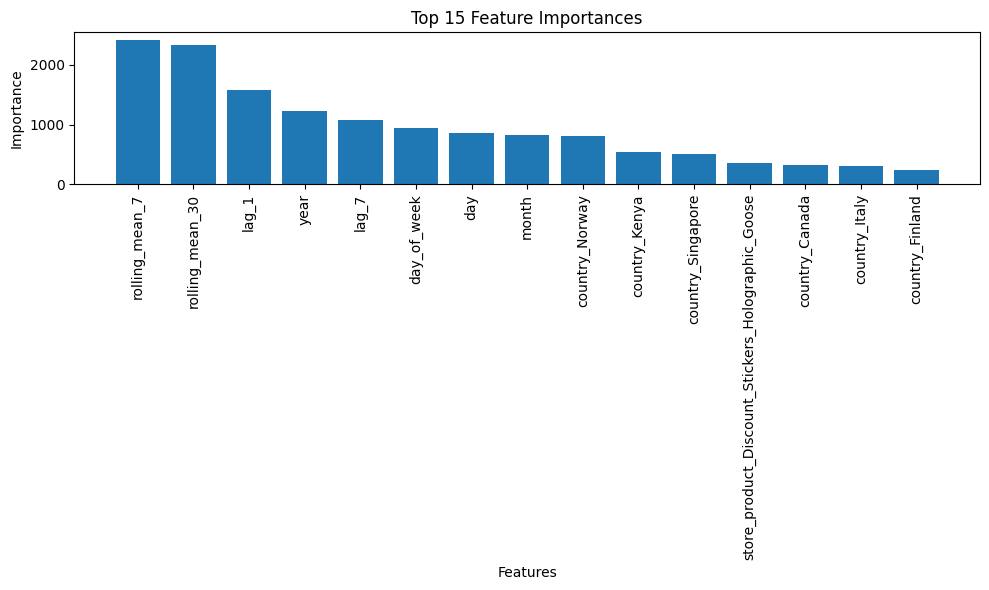

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
import lightgbm as lgb

def time_series_modeling(train_df):
    # Select features
    feature_columns = [
        'year', 'month', 'day', 'day_of_week', 'quarter',
        'lag_1', 'lag_7', 'rolling_mean_7', 'rolling_mean_30',
        'store', 'product', 'country', 'store_product'
    ]
    
    # Prepare feature matrix
    X = train_df[feature_columns]
    y = train_df['num_sold']
    
    # Encode categorical features
    X = pd.get_dummies(X, columns=['store', 'product', 'country', 'store_product'])
    
    # Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Model parameters
    model_params = {
        'objective': 'regression',
        'metric': 'mape',
        'n_estimators': 500,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
    }
    
    # Store results
    mape_scores = []
    models = []
    
    # Cross-validation
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Train model
        model = lgb.LGBMRegressor(**model_params)
        model.fit(X_train, y_train)
        
        # Predict and calculate MAPE
        y_pred = model.predict(X_val)
        mape = mean_absolute_percentage_error(y_val, y_pred)
        mape_scores.append(mape)
        models.append(model)
    
    # Print validation results
    print("Cross-Validation MAPE Scores:", mape_scores)
    print("Mean MAPE:", np.mean(mape_scores))
    
    # Select best model (lowest MAPE)
    best_model = models[np.argmin(mape_scores)]
    
    return best_model

def make_predictions(model, test_df):
    # Select same features used in training
    feature_columns = [
        'year', 'month', 'day', 'day_of_week', 'quarter',
        'lag_1', 'lag_7', 'rolling_mean_7', 'rolling_mean_30',
        'store', 'product', 'country', 'store_product'
    ]
    
    # Prepare test feature matrix
    X_test = test_df[feature_columns]
    
    # Encode categorical features
    X_test = pd.get_dummies(X_test, columns=['store', 'product', 'country', 'store_product'])
    
    # Ensure test features match training features
    train_columns = model.feature_name_
    for col in train_columns:
        if col not in X_test.columns:
            X_test[col] = 0
    
    # Reorder columns to match training
    X_test = X_test[train_columns]
    
    # Make predictions
    predictions = model.predict(X_test)
    
    # Prepare submission dataframe
    submission_df = pd.DataFrame({
        'id': test_df['id'],
        'num_sold': predictions
    })
    
    return submission_df

# Train the model
best_model = time_series_modeling(train_df_with_features)

# Generate predictions
submission = make_predictions(best_model, test_df_with_features)

# Save predictions
submission.to_csv('submission.csv', index=False)

# Feature Importance Visualization
def plot_feature_importance(model):
    feature_imp = pd.DataFrame({
        'feature': model.feature_name_,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.bar(feature_imp['feature'][:15], feature_imp['importance'][:15])
    plt.title('Top 15 Feature Importances')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Plot feature importances
plot_feature_importance(best_model)

In [105]:
# Check submission file
submission = pd.read_csv('submission.csv')
print(submission.head())
print(submission.info())
print(f"Total predictions: {len(submission)}")

       id    num_sold
0  230130  293.937427
1  230131  741.177678
2  230132  614.593170
3  230133  353.505647
4  230134  394.041014
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98550 entries, 0 to 98549
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        98550 non-null  int64  
 1   num_sold  98550 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 1.5 MB
None
Total predictions: 98550
